# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
# # Detect hardware, return appropriate distribution strategy
# import tensorflow as tf
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

tpu = False

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.optim import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split


if tpu:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
t1 = torch.ones(3, 3, device = device)
t1

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [5]:
# !pip install transformers -U
# !pip install IProgress
# !pip install sentencepiece

In [6]:
!pip install torcheval
!pip install torchview

#Comment out if not tpu
if tpu:
    !pip install transformers -U
    !pip install IProgress
    !pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.7 MB/s eta 0:00:00


In [7]:
from transformers import BertTokenizer, BertModel,TFBertModel, AutoTokenizer,XLMRobertaTokenizer,XLMRobertaModel
from torcheval.metrics.functional import multiclass_f1_score

#display progress
from tqdm.auto import tqdm
tqdm.pandas()



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# EDA

In [8]:
train_full = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
submit_data = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

Breakdown of languages present in the dataset

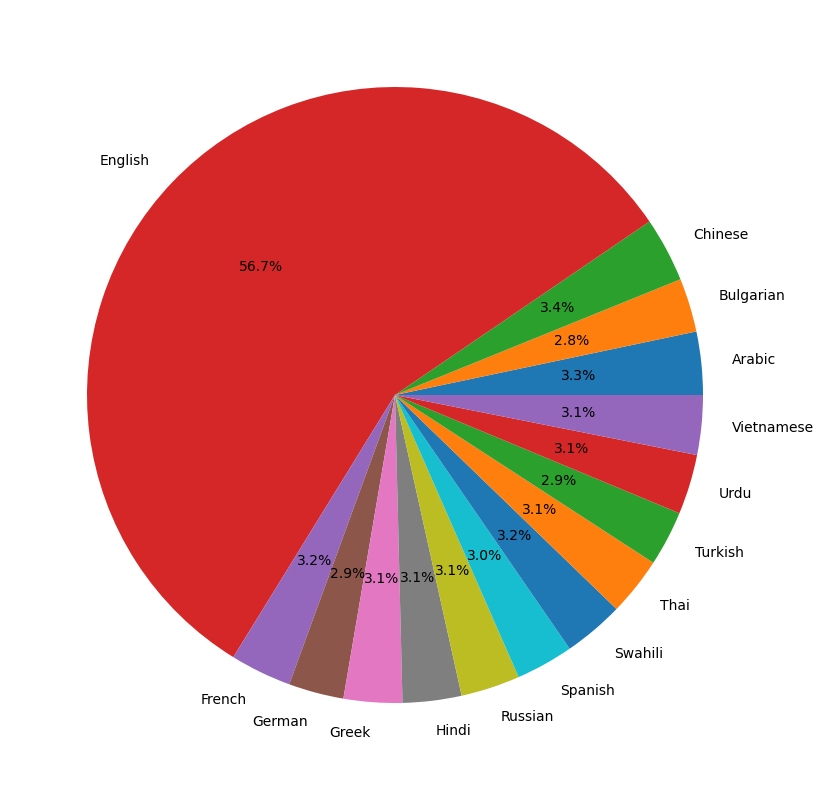

In [9]:
labels, frequencies = np.unique(train_full.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

# Data Preprocessing

In [10]:
def remove_non_ascii(data: pd.Series) -> pd.Series:
    """Removes a custom set of non-ASCII characters.

    :param data: a Series of text data

    """
    return data.str.replace(r'[^\x00-\x7F]+', repl='', regex=True)

def remove_encoded_text(data: pd.Series) -> pd.Series:
    """Removes encoded text.

    :param data: a Series of text data

    """
    return data.str.replace('&#039;', "'")

def fix_special_characters(data: pd.Series) -> pd.Series:
    """Fixes special characters that have the full character code
    in the raw text and replaces them with the character only.

    replaces '&amp;' with 'and'
    replaces '&#039;' with "''

    :param data: a Series of text data

    """
    data_ = data.str.replace('&amp;', 'and')
    data_ = data_.str.replace('&#039;', "'")
    return data_


def to_lowercase(data: pd.Series) -> pd.Series:
    """Puts all text to lowercase.

    :param data: a Series of text data

    """
    return data.str.lower()

def shrink_whitespace(data: pd.Series) -> pd.Series:
    """Sets whitespace to a single space.

    :param data: a Series of text data

    """
    return data.str.replace(r'\s+', repl=' ', regex=True)

In [11]:
def clean_data(df: pd.DataFrame,text_col='text') -> pd.DataFrame:
    """
    Clean data
    """
    df[text_col] = remove_non_ascii(df[text_col])
    df[text_col] = remove_encoded_text(df[text_col])
    df[text_col] = fix_special_characters(df[text_col])
    df[text_col] = to_lowercase(df[text_col])
    df[text_col] = shrink_whitespace(df[text_col])

    return df

In [12]:
def get_tokens(text,tokenizer,roberta=False):
    if roberta:
        text = f"<s> {text} </s>"
    else:
        text = f"[CLS] {text} [SEP]"
    tokenized_text = tokenizer.tokenize(text)
    if roberta:
        sen_sep_id = np.where(np.array(tokenized_text)=='</s>')[0][0] #index where premise starts
    else:
        sen_sep_id = np.where(np.array(tokenized_text)=='[SEP]')[0][0] #index where premise starts
    tokens = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    
    hypo_ids = torch.zeros((sen_sep_id))
    per_ids = torch.ones(len(tokenized_text)-1-sen_sep_id)
    text_ids_tensor = torch.concat([torch.zeros((1)),hypo_ids,per_ids])
    
    train_dict = {'tokenized_text':tokenized_text,
                  'tokens':tokens,
                  'text_ids':text_ids_tensor}
    
    return tokenized_text,tokens,text_ids_tensor


In [13]:
# bert_model = BertModel.from_pretrained('bert-base-multilingual-uncased',
#            output_hidden_states = True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [14]:
tokenizer.sep_token

'</s>'

In [15]:
def prep_data(df,clean_data_bool = True,roberta=False):
    if clean_data_bool:
        df = clean_data(df,"premise")
        df = clean_data(df,"hypothesis")
    df['full_text'] = df["hypothesis"]+f" {tokenizer.sep_token} "+df["premise"]
#     df[['tokenized_text','tokens','text_ids']] = df.progress_apply(lambda s:get_tokens(s['full_text'],tokenizer,roberta),axis=1,result_type='expand')
    
#     if roberta:
#         pad = 1
#     else:
#         pad = 0
    
#     tokens = torch.squeeze(torch.nested.to_padded_tensor(torch.nested.nested_tensor(df['tokens'].tolist()),pad))
#     text_ids = torch.squeeze(torch.nested.to_padded_tensor(torch.nested.nested_tensor(df['text_ids'].tolist()),pad))
#     mask = torch.squeeze(torch.nested.to_padded_tensor(torch.ones_like(torch.nested.nested_tensor(df['tokens'].tolist())),pad))
    
#     model_data = {
#       'input_ids': tokens.int(),#.swapaxes(0,1), # KM: input_word_ids hasn't been padded yet - do it here now
#       'token_type_ids': text_ids.int(),
#       'attention_mask': mask.int()
#       }

    if roberta:
        df['full_text'] = "<s> "+df['full_text']+" </s>"
    else:
        df['full_text'] = "[CLS] "+df['full_text']+" [SEP]"
    df['full_text'] = df['full_text']
    model_data = tokenizer(df['full_text'].to_list(), padding=True)
    model_data = {k:torch.tensor(v) for k,v in model_data.items()}
    if 'token_type_ids' not in model_data:
        model_data['token_type_ids'] = torch.zeros(model_data['input_ids'].shape)


    return df,model_data

## Data Cleaning and seperation

Currently data cleaning is turned off.

Data is split into 3 buckets (train,validation,test)


    Train and validaiton will be used to fine tune and find the best model/parameters
    Test set will only be run once the final model and parameters are choosen

In [16]:
# Seperate train, val and test set
train_full = train_full.sample(frac=1,random_state=123) #shuffle the data from the original state
train_val, test = train_test_split(train_full, test_size=0.2) 
train, val = train_test_split(train_val, test_size=0.2)

In [17]:
df_train_clean,model_train_data = prep_data(train,False,True)
df_val_clean,model_val_data = prep_data(val,False,True)
df_test_clean,model_test_data = prep_data(test,False,True)

# Model

Dataset class for storing the tokenized text and labels

In [18]:
class CustomDataset(Dataset):
    def __init__(self, data,labels):
        self.input_ids = data['input_ids'].to(device)
        self.token_type_ids = data['token_type_ids'].to(device)
        self.attention_mask = data['attention_mask'].to(device)
        self.labels = torch.tensor(labels).to(device)


    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        batch_data = {'input_ids':self.input_ids[idx],
                     'token_type_ids':self.token_type_ids[idx],
                     'attention_mask':self.attention_mask[idx]}
        return batch_data, self.labels[idx]

Main training function:
- Uses Crossentropy loss
- Adam as the optimizer
- Uses the train set to train the model and validation set to validate the models performance each epoch

In [19]:
def run_train(model, train_data, train_df,val_data, val_df, learning_rate, epochs,batch_size=20):
    loss_list_train = []
    acc_list_train = []
    f1_list_train = []
    loss_list_val = []
    acc_list_val = []
    f1_list_val = []
    
    criterion = nn.CrossEntropyLoss().to(device) #Multi Class loss https://www.cs.toronto.edu/~lczhang/321/tut/tut04.pdf
    #criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

    trainDataset = CustomDataset(train_data,train_df['label'].values)
    train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
    
    valDataset = CustomDataset(val_data,val_df['label'].values)
    val_dataloader = torch.utils.data.DataLoader(valDataset, batch_size=batch_size, shuffle=True)
    for epoch_num in range(epochs):
       
        outputs_train = torch.empty(0,3).to(device)
        ys_train = torch.empty(0,dtype=torch.int64).to(device)

        for i,[X_train,y_train] in enumerate(tqdm(train_dataloader)):

            output = model(X_train['input_ids'].to(device),X_train['token_type_ids'].to(device),X_train['attention_mask'].to(device))
            outputs_train = torch.cat((outputs_train,output))
            ys_train = torch.cat((ys_train,y_train))

            batch_loss = criterion(output, y_train)          
            
            #CUDA
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #xm.optimizer_step(optimizer) # TPU
            
        batch_loss_train = criterion(outputs_train, ys_train).item()
        f1_train = multiclass_f1_score(outputs_train,ys_train,num_classes=3,average='weighted')
        acc_train = metrics.accuracy_score(ys_train.detach().cpu().numpy(), outputs_train.argmax(dim=1).detach().cpu().numpy())

        with torch.no_grad():
            outputs_val = torch.empty(0,3).to(device)
            ys_val = torch.empty(0,dtype=torch.int64).to(device)
            
            for X_val,y_val in val_dataloader:
                output = model(X_val['input_ids'].to(device),X_val['token_type_ids'].to(device),X_val['attention_mask'].to(device))
                outputs_val = torch.cat((outputs_val,output))
                ys_val = torch.cat((ys_val,y_val))
                
        batch_loss_val = criterion(outputs_val, ys_val).item()
        f1_val = multiclass_f1_score(outputs_val,ys_val,num_classes=3,average='weighted')
        acc_val = metrics.accuracy_score(ys_val.detach().cpu().numpy(), outputs_val.argmax(dim=1).detach().cpu().numpy())
        
                
        print(
            f'Epochs: {epoch_num + 1}\
            \n| Train Loss: {batch_loss_train: .3f} \
            | Train Accuracy: {acc_train: .3f}\
            | Train F1: {f1_train: .3f} \
            \n| Val Loss: {batch_loss_val: .3f} \
            | Val Accuracy: {acc_val: .3f} \
            | Val F1: {f1_val: .3f} ')
        
        loss_list_train.append(batch_loss_train)
        acc_list_train.append(acc_train)
        f1_list_train.append(f1_train)
        
        loss_list_val.append(batch_loss_val)
        acc_list_val.append(acc_val)
        f1_list_val.append(f1_val)
        
    return loss_list_train,acc_list_train,f1_list_train,loss_list_val,acc_list_val,f1_list_val, model

## Current model
Uses a version of an XLMRoberta Model with two additional linear and droput layers on the CLS values of the last hidden layer of the Roberta model

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
class NNClassifier(nn.Module):

    def __init__(self, dropout=0.3):
        super(NNClassifier, self).__init__()
        #Embeddings
#         self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.xlm = XLMRobertaModel.from_pretrained("symanto/xlm-roberta-base-snli-mnli-anli-xnli")

        #dropouts
        self.dropout = nn.Dropout(dropout)

        
        #linear
#         self.linear_768_3 = nn.Linear(768, 3)
        self.linear_768_192 = nn.Linear(768, 192)
        self.linear_192_3 = nn.Linear(192, 3)
                
        
        #activations
        self.sfmax = nn.Softmax(dim=0)
        

    def forward(self, input_ids,token_type_ids,attention_mask):

        #last_hidden, pooled_output = self.bert(input_ids= input_ids.long(), attention_mask=attention_mask.long(),token_type_ids =token_type_ids.long(),return_dict=False) 
        xlm_out = self.xlm(input_ids= input_ids.long(), attention_mask=attention_mask.long(),return_dict=True) 

#         linear_768_200 = self.linear_768_200(last_hidden[:, 0,:])
        dropout_output = self.dropout(xlm_out.last_hidden_state[:, 0,:])
    
        linear_768_192 = self.linear_768_192(dropout_output)
        dropout_output = self.dropout(linear_768_192)
        
        linear_output = self.linear_192_3(dropout_output)
            
        #Activations
#         linear_output = self.sfmax(linear_output)

        return linear_output

## Possible Future Model
Possible future model to improve current results: Use RNN on last hidden layer of bert

In [21]:
#NOT USED: 
class RNNClassifier(nn.Module):

    def __init__(self, dropout=0.6):
        super(NNClassifier, self).__init__()
        #Embeddings
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        #dropouts
        self.dropout = nn.Dropout(dropout)
                
        # RNN
        self.hidden_dim = 30
        self.layer_dim = 3
        self.rnn = nn.RNN(768, self.hidden_dim, self.layer_dim, batch_first=True)
        
        #linear
        self.lin_rnnHid_3 = nn.Linear(self.hidden_dim, 3)

    def forward(self, input_ids,token_type_ids,attention_mask):

        last_hidden, pooled_output = self.bert(input_ids= input_ids.long(), attention_mask=attention_mask.long(),token_type_ids =token_type_ids.long(),return_dict=False) 
        print('here')
        
        h0 = torch.zeros(self.layer_dim, last_hidden.shape[0], self.hidden_dim,requires_grad=True).to(device)
        print(last_hidden.shape)
        print(h0.shape)
#         print(torch.unsqueeze(last_hidden[:, 0,:], dim=0).shape)
        rnn_output, hn = self.rnn(last_hidden[:, :,:],h0)
        print(rnn_output.shape)
        
        linear_output = self.lin_rnnHid_3(rnn_output)
        dropout_output = self.dropout(linear_output)

        return dropout_output

In [22]:
model = NNClassifier()
model= nn.DataParallel(model,device_ids=[0, 1])
model.to(device)


Some weights of the model checkpoint at symanto/xlm-roberta-base-snli-mnli-anli-xnli were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at symanto/xlm-roberta-base-snli-mnli-anli-xnli and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to us

DataParallel(
  (module): NNClassifier(
    (xlm): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobertaSelfOutput(
                (dense): Li

# Run Training

In [25]:
EPOCHS = 5
LR = 1e-5 #1e-5
loss_list_train,acc_list_train,f1_list_train,loss_list_val,acc_list_val,f1_list_val, model = run_train(model, model_train_data, df_train_clean, model_val_data, df_val_clean, LR, EPOCHS,batch_size=35)

  0%|          | 0/222 [00:00<?, ?it/s]

Epochs: 1            
| Train Loss:  0.646             | Train Accuracy:  0.722            | Train F1:  0.718             
| Val Loss:  0.431             | Val Accuracy:  0.845             | Val F1:  0.844 


  0%|          | 0/222 [00:00<?, ?it/s]

Epochs: 2            
| Train Loss:  0.278             | Train Accuracy:  0.904            | Train F1:  0.904             
| Val Loss:  0.422             | Val Accuracy:  0.846             | Val F1:  0.845 


  0%|          | 0/222 [00:00<?, ?it/s]

Epochs: 3            
| Train Loss:  0.132             | Train Accuracy:  0.958            | Train F1:  0.958             
| Val Loss:  0.436             | Val Accuracy:  0.852             | Val F1:  0.852 


  0%|          | 0/222 [00:00<?, ?it/s]

Epochs: 4            
| Train Loss:  0.057             | Train Accuracy:  0.984            | Train F1:  0.984             
| Val Loss:  0.540             | Val Accuracy:  0.847             | Val F1:  0.847 


  0%|          | 0/222 [00:00<?, ?it/s]

Epochs: 5            
| Train Loss:  0.035             | Train Accuracy:  0.991            | Train F1:  0.991             
| Val Loss:  0.658             | Val Accuracy:  0.850             | Val F1:  0.849 


# Evaluations

Run only once final model & parameters chosen


Use the test set as an unseen set of data to see models performance

In [26]:
def get_preds(df,model_data,mdl, batch_size=20):

    predDataset = CustomDataset(model_data,[-1]*df.shape[0])
    pred_dataloader = torch.utils.data.DataLoader(predDataset, batch_size=batch_size, shuffle=False)
    predictions = []
    outputs = []
    for i,[X,_] in enumerate(tqdm(pred_dataloader)):


        with torch.no_grad():
            output = mdl(X['input_ids'].to(device),X['token_type_ids'].to(device),X['attention_mask'].to(device))
            predictions.extend(output.argmax(dim=1).cpu().numpy())
            outputs.extend(output.cpu().numpy())
    return predictions,outputs

In [27]:
predictions,outputs = get_preds(df_test_clean,model_test_data,model)
df_test_clean['prediction'] = predictions
df_test_clean['outputs'] = outputs

  0%|          | 0/122 [00:00<?, ?it/s]

In [28]:
metrics.accuracy_score(df_test_clean['label'],df_test_clean['prediction'])

0.8556105610561056

In [29]:
metrics.f1_score(df_test_clean['label'],df_test_clean['prediction'],average='weighted')

0.8554836720418402

In [30]:
metrics.confusion_matrix(df_test_clean['label'],df_test_clean['prediction'])

array([[688,  68,  35],
       [ 61, 635,  85],
       [ 35,  66, 751]])

# Predictions

Generate final prediction file

In [31]:
df_submit_clean, model_data_submit = prep_data(submit_data,False,True)

![](http://)

In [32]:
df_submit_clean['prediction'] = get_preds(df_submit_clean,model_data_submit,model)[0]

  0%|          | 0/260 [00:00<?, ?it/s]

In [33]:
df_submit_clean[['id','prediction']].to_csv('submission.csv',index=False)